In [2]:
from dotenv import dotenv_values, find_dotenv
import os


dotenv_path = find_dotenv()


if not dotenv_path:
    print("❌ Error: Could not find the .env file in this directory or any parent directories.")
else:
    print(f"✅ Found .env file at: {dotenv_path}\n")
    
    
    config = dotenv_values(dotenv_path)

    if not config:
        print(f"⚠️ The .env file is empty or could not be parsed.")
    else:
        print(f"🔑 --- Checking Keys Found ---")
        for key, value in config.items():
            if value:
                
                print(f"  - Key: {key}, Length: {len(value)}")
            else:
                print(f"  - Key: {key}, Value: (empty)")
        print("-----------------------------")

✅ Found .env file at: d:\Ai agents\iambesideyou\.env

🔑 --- Checking Keys Found ---
  - Key: LANGSMITH_TRACING, Length: 4
  - Key: LANGSMITH_API_KEY, Length: 51
  - Key: GOOGLE_API_KEY, Length: 39
  - Key: TAVILY_API_KEY, Length: 41
  - Key: LANGSMITH_PROJECT, Length: 17
  - Key: OPENAI_API_KEY, Length: 164
-----------------------------


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage,AnyMessage,ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

builder= StateGraph(MessagesState)

builder.add_node()

In [3]:
import os
from dotenv import load_dotenv
import sys 


load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")


if not api_key:
    print("🚨 Error: GOOGLE_API_KEY not found in .env file.")
    sys.exit(1) 

if len(api_key) < 30: 
    print("🚨 Error: The provided GOOGLE_API_KEY seems too short to be valid.")
    sys.exit(1)

print("✅ Google API Key loaded and validated successfully.")

✅ Google API Key loaded and validated successfully.


In [4]:


import os
from typing import TypedDict, Annotated, List
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


@tool
def add_subject(subject: str) -> str:
    """Adds a subject to the list of subjects."""
    return f"Successfully added '{subject}'. The user should be notified of this success."


@tool
def delete_subject(subject: str) -> str:
    """Deletes a subject from the list of subjects."""
    return f"Successfully deleted '{subject}'. The user should be notified of this success."

tools = [add_subject, delete_subject]


class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]
    subjects: List[str]



def call_model(state: GraphState):
    print("---AGENT---")
    messages = state['messages']
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


tool_node = ToolNode(tools)



def update_state_from_tool_calls(state: GraphState) -> GraphState:
    print("---UPDATING SUBJECTS LIST---")
    last_message = state['messages'][-1]
    
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return state

    current_subjects = state.get('subjects', [])
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call.get('name')
        tool_args = tool_call.get('args', {})
        subject = tool_args.get('subject')
        
        if not subject:
            continue

        if tool_name == 'add_subject':
            if subject not in current_subjects:
                print(f"Adding '{subject}' to the list.")
                current_subjects.append(subject)
        elif tool_name == 'delete_subject':
            if subject in current_subjects:
                print(f"Deleting '{subject}' from the list.")
                current_subjects.remove(subject)

    
    return {"subjects": current_subjects}



def should_continue(state: GraphState):
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue_to_tools"
    else:
        return "end_conversation"


workflow = StateGraph(GraphState)

# Add the nodes
workflow.add_node("agent", call_model)
workflow.add_node("update_state", update_state_from_tool_calls)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.set_entry_point("agent")

# Add the conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue_to_tools": "update_state", 
        "end_conversation": END,
    },
)


workflow.add_edge("update_state", "tools")
workflow.add_edge("tools", "agent") 


app = workflow.compile()

print("Graph compiled! You can now interact with it.")

Graph compiled! You can now interact with it.


In [5]:

initial_state = {
    "messages": [HumanMessage(content="Hi! Can you please add 'Physics' to my subjects?")],
    "subjects": ["Chemistry", "Biology"] 
}

final_state = app.invoke(initial_state)


print("\n---FINAL RESPONSE---")
print(final_state['messages'][-1].content)
print("\n---UPDATED SUBJECTS---")
print(final_state['subjects'])

---AGENT---
---UPDATING SUBJECTS LIST---
Adding 'Physics' to the list.
---AGENT---

---FINAL RESPONSE---
OK. I've added Physics to your subjects. Anything else?

---UPDATED SUBJECTS---
['Chemistry', 'Biology', 'Physics']


In [6]:

initial_state_delete = {
    "messages": [HumanMessage(content="You know what, please remove 'Chemistry'")],
    "subjects": ["Chemistry", "Biology", "Physics"] 
}

final_state_delete = app.invoke(initial_state_delete)


print("\n---FINAL RESPONSE---")
print(final_state_delete['messages'][-1].content)
print("\n---UPDATED SUBJECTS---")
print(final_state_delete['subjects'])

---AGENT---
---UPDATING SUBJECTS LIST---
Deleting 'Chemistry' from the list.
---AGENT---

---FINAL RESPONSE---
OK. I've removed 'Chemistry'. Anything else?

---UPDATED SUBJECTS---
['Biology', 'Physics']


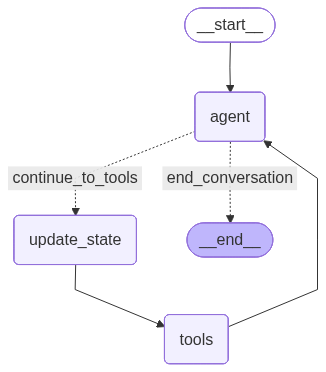

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
import os
from typing import TypedDict, Annotated, List, Dict
import json
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode







class Topic(TypedDict):
    name: str
    completed: bool

class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]
    study_plan: Dict[str, List[Topic]]



@tool
def add_subject(subject: str) -> str:
    """Adds a new subject to the study plan. Use this to create a subject before adding topics to it."""

    return f"Successfully added subject '{subject}'. The user can now add topics to it."

@tool
def delete_subject(subject: str) -> str:
    """Deletes a subject and all its topics from the study plan."""
    return f"Successfully deleted subject '{subject}'."


@tool
def add_topics_to_subject(subject: str, topics: List[str]) -> str:
    """Adds a list of new topics to a specified subject. All topics are added as 'incomplete' by default."""
    return f"Successfully added {len(topics)} topics to '{subject}'. The user should be notified."

@tool
def mark_topic_as_completed(subject: str, topic: str) -> str:
    """Marks a specific topic within a subject as completed."""
    return f"Successfully marked '{topic}' in '{subject}' as completed. The user should be notified."

@tool
def list_topics(subject: str) -> str:
    """Lists all topics for a subject, noting which are complete and which are incomplete."""
    
    return f"Topic list for '{subject}' has been retrieved and will be provided to the user."



tools = [add_subject, delete_subject, add_topics_to_subject, mark_topic_as_completed, list_topics]


def update_state_from_tool_calls(state: GraphState) -> GraphState:
    print("---UPDATING STUDY PLAN---")
    last_message = state['messages'][-1]
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return state

    # Make a copy to avoid modifying the state in place
    new_plan = state.get('study_plan', {}).copy()

    for tool_call in last_message.tool_calls:
        tool_name = tool_call.get('name')
        tool_args = tool_call.get('args', {})
        subject = tool_args.get('subject')

        # Logic for each tool
        if tool_name == 'add_subject':
            if subject and subject not in new_plan:
                new_plan[subject] = []
                print(f"Added subject: {subject}")

        elif tool_name == 'delete_subject':
            if subject and subject in new_plan:
                del new_plan[subject]
                print(f"Deleted subject: {subject}")

        elif tool_name == 'add_topics_to_subject':
            topics_to_add = tool_args.get('topics', [])
            if subject and subject in new_plan and topics_to_add:
                existing_topic_names = {t['name'] for t in new_plan[subject]}
                for topic_name in topics_to_add:
                    if topic_name not in existing_topic_names:
                        new_plan[subject].append({"name": topic_name, "completed": False})
                print(f"Added topics to {subject}: {topics_to_add}")

        elif tool_name == 'mark_topic_as_completed':
            topic_to_mark = tool_args.get('topic')
            if subject and topic_to_mark and subject in new_plan:
                for topic_obj in new_plan.get(subject, []):
                    if topic_obj['name'] == topic_to_mark:
                        topic_obj['completed'] = True
                        print(f"Marked '{topic_to_mark}' in '{subject}' as complete.")
                        break
                        
        elif tool_name == 'list_topics':
          
            if subject in new_plan:
                
                tool_call_id = tool_call.get('id')
                subject_data = new_plan[subject]
                observation = json.dumps(subject_data)
               
                tool_message = ToolMessage(content=observation, tool_call_id=tool_call_id)
                
                
                for i, msg in enumerate(state['messages']):
                    if isinstance(msg, ToolMessage) and msg.tool_call_id == tool_call_id:
                        state['messages'][i] = tool_message
                        break


    return {"study_plan": new_plan}



model = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest", temperature=0)
model_with_tools = model.bind_tools(tools)

def call_model(state: GraphState):
    print("---AGENT---")

    current_plan_str = json.dumps(state['study_plan'])
    state['messages'].append(
        HumanMessage(content=f"Here is the current study plan for your reference: {current_plan_str}")
    )
    response = model_with_tools.invoke(state['messages'])
    return {"messages": [response]}

tool_node = ToolNode(tools)


def should_continue(state: GraphState):
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue_to_tools"
    else:
        return "end_conversation"


workflow = StateGraph(GraphState)

workflow.add_node("agent", call_model)
workflow.add_node("update_state", update_state_from_tool_calls)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue_to_tools": "update_state", "end_conversation": END},
)

workflow.add_edge("update_state", "tools")
workflow.add_edge("tools", "agent")


sam = workflow.compile()
print("Graph compiled! You can now interact with the Study Planner.")

Graph compiled! You can now interact with the Study Planner.


In [9]:

state = {
    "messages": [HumanMessage(content="Hey, I want to start studying Physics. Can you add topics: Kinematics, Optics, and Thermodynamics?")],
    "study_plan": {} # Start with an empty plan
}


final_state = sam.invoke(state)

print("\n---FINAL RESPONSE 1---")
print(final_state['messages'][-1].content)
print("\n---UPDATED STUDY PLAN 1---")
print(json.dumps(final_state['study_plan'], indent=2))


state_2 = final_state
state_2['messages'].append(HumanMessage(content="Great. I've just finished studying Optics."))

final_state_2 = sam.invoke(state_2)

print("\n---FINAL RESPONSE 2---")
print(final_state_2['messages'][-1].content)
print("\n---UPDATED STUDY PLAN 2---")
print(json.dumps(final_state_2['study_plan'], indent=2))


state_3 = final_state_2
state_3['messages'].append(HumanMessage(content="What should I study next in Physics?"))

final_state_3 = app.invoke(state_3)

print("\n---FINAL RESPONSE 3---")
print(final_state_3['messages'][-1].content)
print("\n---FINAL STUDY PLAN 3---")
print(json.dumps(final_state_3['study_plan'], indent=2))

---AGENT---


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_input_token_count"
  quota_id: "GenerateContentInputTokensPerModelPerMinute-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
}
violations {
  quota_metric: "generativelanguage.googleapis.com/gener

KeyboardInterrupt: 

In [ ]:

state = {
    "messages": [HumanMessage(content="Hey, I want to start studying Physics. Can you add topics: Kinematics, Optics, and Thermodynamics?")],
    "study_plan": {} # Start with an empty plan
}


final_state = sam.invoke(state)

print("\n---FINAL RESPONSE 1---")
print(final_state['messages'][-1].content)
print("\n---UPDATED STUDY PLAN 1---")
print(json.dumps(final_state['study_plan'], indent=2))


state_2 = final_state
state_2['messages'].append(HumanMessage(content="Great. I've just finished studying Optics."))

final_state_2 = sam.invoke(state_2)

print("\n---FINAL RESPONSE 2---")
print(final_state_2['messages'][-1].content)
print("\n---UPDATED STUDY PLAN 2---")
print(json.dumps(final_state_2['study_plan'], indent=2))


state_3 = final_state_2
state_3['messages'].append(HumanMessage(content="What should I study next in Physics?"))

final_state_3 = app.invoke(state_3)

print("\n---FINAL RESPONSE 3---")
print(final_state_3['messages'][-1].content)
print("\n---FINAL STUDY PLAN 3---")
print(json.dumps(final_state_3['study_plan'], indent=2))